In [68]:
import cv2 as cv
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import axes3d    

import numpy as np
import os
import pandas as pd
import joblib
plt.style.use('dark_background') 

%matplotlib inline

PATH = 'C:/Users/yanet/Documents/CV/placas/'
archivos = os.listdir(PATH)

In [69]:

modelo_cargado = joblib.load('modelo_entrenado_s.pkl')

In [70]:
# Carga de las funciones del modulo plot
def imgnorm(img):
    """Nomalize an image
    Args:
        img (numpy array): Source image
    Returns:
        normalized (numpy array): Nomalized image
    """
    vmin, vmax = img.min(), img.max()
    normalized_values = []
    delta = vmax-vmin

    for p in img.ravel():
        normalized_values.append(255*(p-vmin)/delta)

    normalized  = np.array(normalized_values).astype(np.uint8).reshape(img.shape[0],-1)
    return normalized

In [71]:
# Carga de las funciones del modulo plot
def imgcmp(img1, img2, title1=None, title2=None, filename=None, axis=False):

    """
    imgcmp: funcion que permite comparar dos imagenes

    Par:
        img1: matriz de la primera imagen
        img2: matriz de la segunda imagen
        title1: title de la primera imagen
        title2: title de la segunda imagen
        filename: opcional para guardar
        axis: opcional para ver los ejes
    """
    imgs = [img1, img2]
    if isinstance(title2, str):
        titles = [title1, title2] # por si vienen separados para tenerlos en una lista
        # es decir title1="imagen1" y title2="imagen2"
    else:
        titles = title1 # por si vienen en una lista como ["imagen1", "imagen2"]

    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    for i in range(len(axs)):
        ax = axs[i]
        r, c = imgs[i].shape[0:2]
        if len(imgs[i].shape) == 3:
            im = ax.imshow(imgs[i], extent=None)
            if title1:
                ax.set_title(titles[i], fontsize=14)
        else:
            im = ax.imshow(imgs[i], extent=None, cmap='gray', vmin=0, vmax=255)
            if title1:
                ax.set_title(titles[i], fontsize=14)

        if not axis:
            ax.axis('off')
        else:
            ax.grid(c='w')
            ax.xaxis.tick_top()
            ax.xaxis.set_label_position('top') 
            ax.set_xlabel('Columns', fontsize=14)
            ax.set_ylabel('Rows', fontsize=14)
            ax.xaxis.label.set_color('w')
            ax.yaxis.label.set_color('w')
            ax.tick_params(axis='x', colors='w', labelsize=14)
            ax.tick_params(axis='y', colors='w', labelsize=14)
        
    if filename is not None:
        plt.savefig(filename)
    plt.show()

In [72]:
# Carga de las funciones del modulo plot
def imgview(img, title=None, filename=None, axis=False, figsize=None):
    """
    imgview: funcion de visualizacion de imagen

    Par:
        img: matriz de la imagen a visualizar
        title: asignacion de titulo, por default no se coloca titulo
        filename: opcion para guardar la imagen, por default no se realiza la accion
        axis: visualizacion de los ejes, por default no se muestran
    """
    r,c = img.shape[0:2]
    if figsize != None:
        fig = plt.figure(figsize=figsize)
    else:
        k = 8
        fig = plt.figure(figsize=(k,k))
    ax = fig.add_subplot(111)
    
    if len(img.shape) == 3:
        img = ax.imshow(img,extent=None)
    else:
        img = ax.imshow(img,extent=None,cmap='gray',vmin=0,vmax=255)
    if title != None:
        ax.set_title(title,fontsize=14)
    if not axis:
        plt.axis('off')
    else:
        ax.grid(c='w')
        ax.xaxis.tick_top()
        ax.xaxis.set_label_position('top') 
        ax.set_xlabel('Columns',fontsize=14)
        ax.set_ylabel('Rows',fontsize=14)
        ax.xaxis.label.set_color('w')
        ax.yaxis.label.set_color('w')
        ax.tick_params(axis='x', colors='w',labelsize=14)
        ax.tick_params(axis='y', colors='w',labelsize=14)
        
    if filename != None:
        plt.savefig(filename)
    plt.show()

In [73]:
def img_data(im):
    """Redimensiona una imagen y la concatena en un solo array.

    Args:
        im (numpy.uint8): Imagen que se redimensionara.

    Returns:
        numpy.ndarray: Array que contiene la imagen redimensionada.
    """
    im = cv.resize(im, (75, 100))
    im_t = np.concatenate(im, axis=0)
    return im_t

In [74]:
def select_placa(imagen):
    """Selecciona en la imagen el objeto mas cercano a una placa (rectangulo).

    Args:
        imagen (numpy.uint8): Imagen que procesara para determinar el objeto mas cercano a una placa.

    Returns:
        placa: Recorte de la imagen donde solo se encuentra la placa.
        x, y, h, w: Propiedades del recorte de la imagen.
        img_: Imagen con un rectangulo seleccionando la placa.
    """

    im = cv.imread(imagen, cv.IMREAD_COLOR)
    # Imagen en formato RGB
    im = cv.cvtColor(im, cv.COLOR_BGR2RGB)

    # print(f"Procesando imagen:") 
    # Analisis de canales
    b_ch, g_ch, r_ch = cv.split(im)
    b_h = cv.calcHist([b_ch], [0], None, [256], [0, 256])
    g_h = cv.calcHist([g_ch], [0], None, [256], [0, 256])
    r_h = cv.calcHist([r_ch], [0], None, [256], [0, 256])

    # Calculando la varianza
    b_var = np.var(b_h)
    g_var = np.var(g_h)
    r_var = np.var(r_h)

    # Determinando el de menor varianza
    if b_var < g_var and b_var < r_var:
        select_ch = b_ch
    elif g_var < b_var and g_var < r_var:
        select_ch = g_ch
    else:
        select_ch = r_ch

    # Asignando canal
    imgray = select_ch

    # Procesamiento para la imagen
    imgray = imgnorm(imgray)
    _, imgray = cv.threshold(imgray, 210, 255,cv.THRESH_TRUNC)
    _, imgray = cv.threshold(imgray, 60, 255,cv.THRESH_TOZERO)
    imgray = cv.GaussianBlur(imgray, (5,5), 10)
    imgray = imgnorm(imgray)
        
    img = im.copy()
    thresh = cv.adaptiveThreshold(imgray, 255,cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY_INV,17,1)
    contours, hierarchy = cv.findContours(thresh, cv.RETR_TREE,cv.CHAIN_APPROX_SIMPLE)
    # print("Numero de objetos detectados:", len(contours))

    def extent(cnt):
        """Funcion que encuentra la relación entre el area del contorno y el area del rectangulo delimitador.

        Args:
            cnt (numpy.uint8): Contorno a evaluar.

        Returns:
            extent: Medida de la extension encontrada.
        """
        area = cv.contourArea(cnt)
        x,y,w,h = cv.boundingRect(cnt)
        rect_area = w*h
        extent = float(area)/rect_area
        return extent
    
    m, n = 0, 0
    for i, cnt in enumerate(contours):
        ext = extent(cnt)
        ext = round(ext, 2)
        x,y,w,h = cv.boundingRect(cnt)
        img = cv.drawContours(img,[cnt],0,(0,255,0),2)
        img = cv.rectangle(img,(x,y),(x+w,y+h),(0,255,255),2)
        # Extent con mayor proporcion
        if (ext > m):
            n = i 
            m = ext

    # print("--------------------------------")
    # print(f"Objeto # {n+1}, con mayor extend: {m}")
    x, y, w, h = cv.boundingRect(contours[n])
    # Recorte de la imagen donde solo se encuentra la placa
    placa = im[y:y+h, x:x+w]
    img_ = im.copy()
    cv.rectangle(img_, (x, y), (x + w, y + h), (0, 255, 0), 4)
    # Visualizar imagen
    # imgcmp(imgray, thresh)
    # imgcmp(thresh, placa)

    return placa, x, y, h, w, img_

In [75]:
def detect_component(result_placa):
    """Funcion que encuentra los componentes de la placa, es decir, los elementos que identifiquen la placa.

    Args:
        result_placa (numpy.uint8): Imagen de la placa a procesar.

    Returns:
        letras: Muestra la imagen con los componentes seleccionados.
        data_letras: Retorna un dataframe de los componenetes.
    """
    # Preprocesamiento de la placa - recorte del margen
    h, w, _ = result_placa.shape
    c_w = int(0.04 * w)
    c_h = int(0.11 * h)
    x1 = c_w
    y1 = c_h
    x2 = w - c_w
    y2 = h - c_h
    img = result_placa[y1:y2, x1:x2]

    # Procesamiento de la imagen
    imgray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
    imgray = cv.GaussianBlur(imgray, (7,7), 1)
    imgray = imgnorm(imgray)
    hist = cv.calcHist([imgray], [0], None, [256], [0, 256])
    
    # Analisis para seleccion de la binarizacion
    brillo = sum(hist[100:])
    threshold = 0.5
    # print(f"Brillo total sobre 100: {brillo}, total histograma: {sum(hist)}")
    # print(f"Margen para la binarizacion 0.5: {brillo / sum(hist)}")
    if brillo / sum(hist) > threshold:
        img_bin = cv.adaptiveThreshold(imgray, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY_INV, 33, 5)
    else:
        img_bin = cv.adaptiveThreshold(imgray, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY, 23, -2)

    kernel = np.ones((3, 3), np.uint8)
    img_bin = cv.erode(img_bin, kernel, iterations=1)
    components = cv.connectedComponentsWithStats(img_bin, connectivity=4)

    result_image = img.copy()
    contours_area = []
    w_med = []
    h_med = []

    # Busqueda de margenes para filtrar los componentes
    for i in range(1, components[0]):
        x, y, w, h, area = components[2][i]
        contours_area.append(area)
    
    indice_max = np.argmax(contours_area)
    valor_maximo = contours_area[indice_max] * 0.10

    for i in range(1, components[0]):
        x, y, w, h, area = components[2][i]
        if area >= valor_maximo:
            if h > w:
                w_med.append(w)
                h_med.append(h)

    if len(h_med) != 0:
        valor_max_h = (sum(h_med)/len(h_med)) * 1.40
        valor_min_h = (sum(h_med)/len(h_med)) * 0.75
    else:
        valor_max_h = imgray.shape[0]
        valor_min_h = 0

    # print(f"Margen del threshold: {valor_maximo}")
    # print(f"Altura max: {valor_max_h} y altura min: {valor_min_h}")

    # Seleccion de los componentes
    letras = []
    l_letras = []
    x_letras = []
    y_letras = []
    for i in range(1, components[0]):
        x, y, w, h, area = components[2][i]
        if area >= valor_maximo:
            if h > w:
                if h > valor_min_h and h < valor_max_h:
                    letra = img_bin[y:y+h, x:x+w]
                    letras.append(letra)
                    x_letras.append(x)
                    y_letras.append(y)
                    im_t = img_data(letra)
                    l_letras.append(im_t)
                    cv.rectangle(result_image, (x, y), (x + w, y + h), (0, 0, 255), 2) # Dibujando rectangulo

    imgcmp(img_bin, imgray)
    # imgcmp(result_placa, result_image)

    # Preparacion de la data de las letras
    x_letras = pd.DataFrame(x_letras)
    y_letras = pd.DataFrame(y_letras)
    l_letras_ = pd.DataFrame(np.array(l_letras, dtype=np.float64))

    data_letras = pd.concat([x_letras, y_letras], axis=1)
    data_letras = pd.concat([data_letras, l_letras_], axis=1, ignore_index=True)

    return letras, data_letras

In [76]:
def process_data(letras):
    """Funcion que encuentra los caracteres asociados a los componentes.

    Args:
        letras: Informacion de los componentes para determinar el orden correcto y las letras asociadas.

    Returns:
        letras_pred: Muestra una lista con las letras que se asocia a la placa.
    """
    
    # Margen para definir si se hace un subgrupo o no
    margen = (max(letras[1]) - min(letras[1]))/2 + (min(letras[1])) # para dos filas

    # Ordenamiento de los componentes
    if (margen * 1.5) > max(letras[1]):
        letras_placas = letras.sort_values(by=[0]) # solo para una fila
    else:
        a = letras[letras[1] < margen].sort_values(by=[0])
        b = letras[letras[1] >= margen].sort_values(by=[0])
        letras_placas = pd.concat([a, b], axis=0)

    # Seleccion de la data necesario para el modelo
    letras_placas = letras_placas.iloc[: , 2:]

    # Prediciendo las letras...
    letras_pred = modelo_cargado.predict(letras_placas)
    return letras_pred


In [77]:
def final_placa(imagen):
    """Funcion que me retorna las letras detectadas en la imagen.

    Args:
        imagen: Imagen a procesar para encontrar las letras.

    Returns:
        img_: Imagen con las letras detectadas.
        txt: String de las letras de la placa
    """

    result_placa, x, y, h, w, img_ = select_placa(imagen)
    letras, data_letras = detect_component(result_placa)


    try:
        _ = process_data(data_letras)
    except Exception as e:
        _ = [] 

    txt = ""
    for i in _:
        txt += f"{i}"
            
    posicion_texto = (x, y - 10)
    cv.putText(img_, txt, posicion_texto, cv.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), thickness=2)
    imgview(img_)

    return img_, txt

Archivo:  images10.jpg
C:/Users/yanet/Documents/CV/placas/images10.jpg


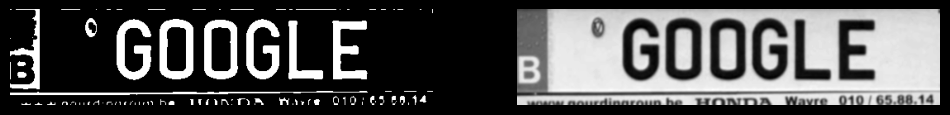

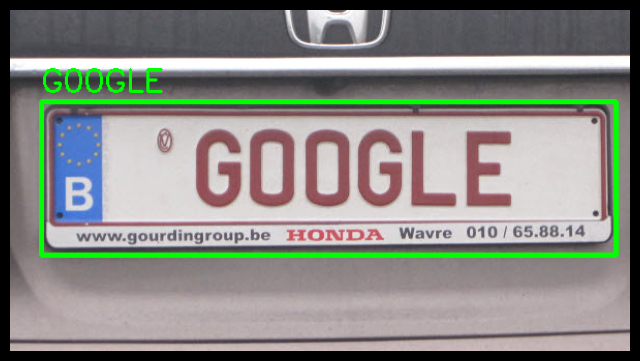

Placa: G00GLE
Archivo:  images100.jpg
C:/Users/yanet/Documents/CV/placas/images100.jpg


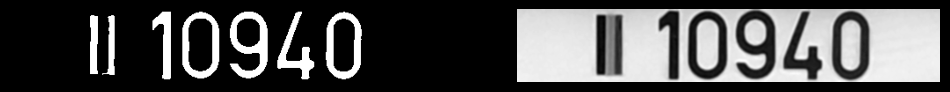

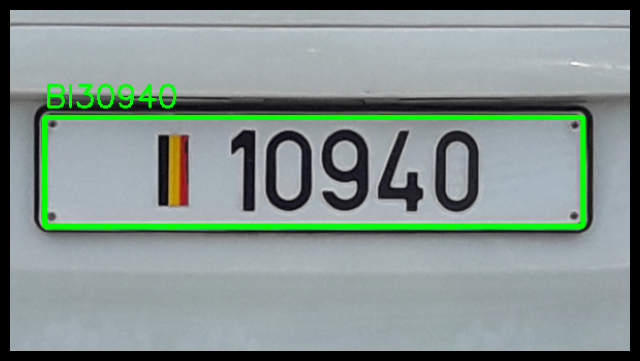

Placa: BI30940
Archivo:  images101.jpg
C:/Users/yanet/Documents/CV/placas/images101.jpg


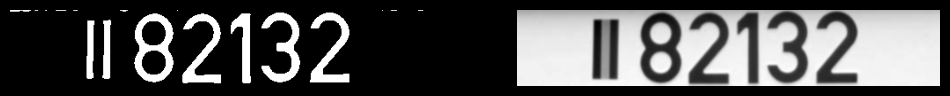

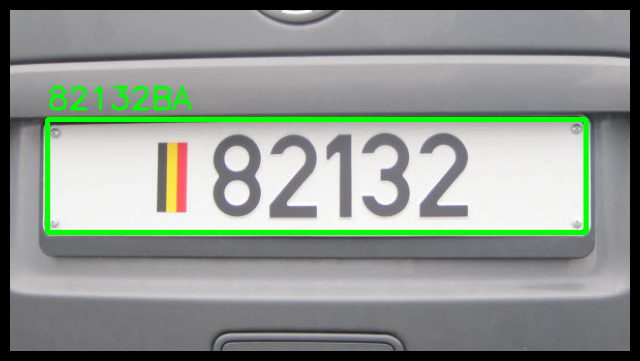

Placa: 82132BA
Archivo:  images102.jpg
C:/Users/yanet/Documents/CV/placas/images102.jpg


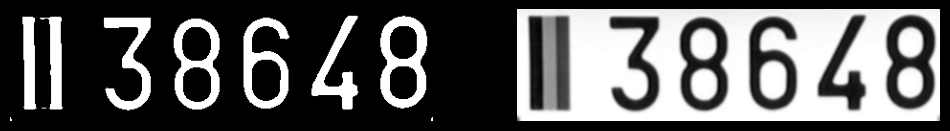

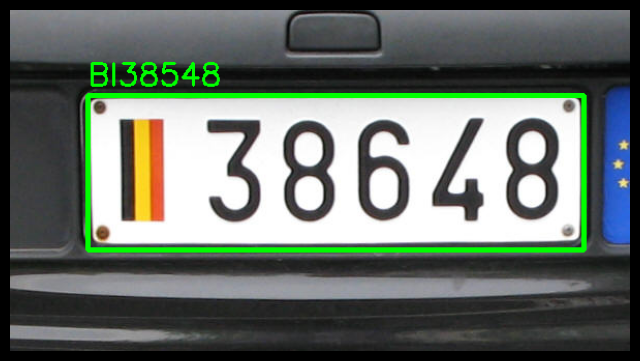

Placa: BI38548
Archivo:  images103.jpg
C:/Users/yanet/Documents/CV/placas/images103.jpg


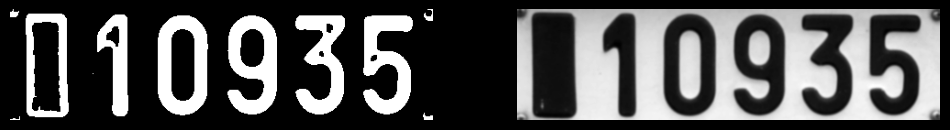

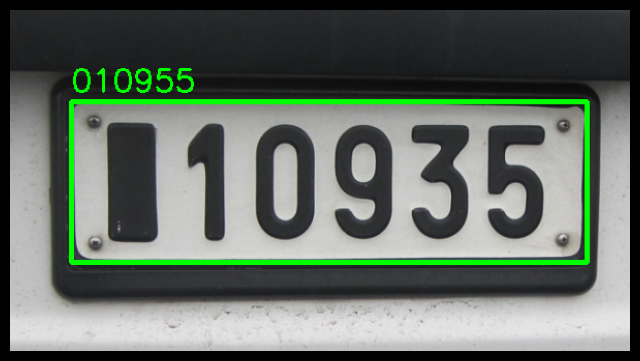

Placa: 010955
Archivo:  images104.jpg
C:/Users/yanet/Documents/CV/placas/images104.jpg


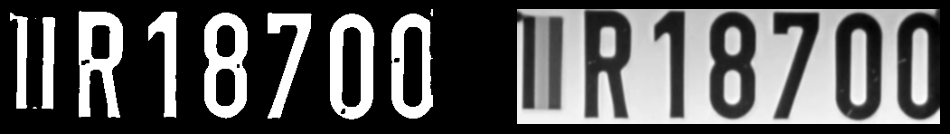

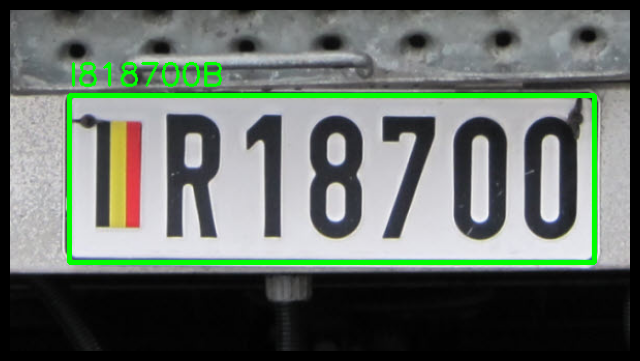

Placa: I818700B
Archivo:  images105.jpg
C:/Users/yanet/Documents/CV/placas/images105.jpg


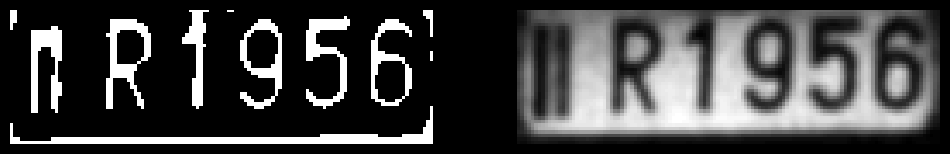

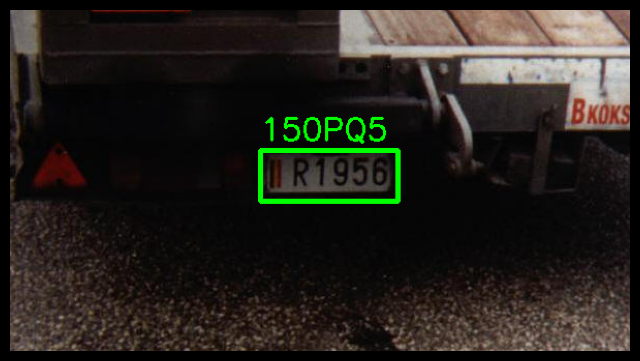

Placa: 150PQ5
Archivo:  images106.jpg
C:/Users/yanet/Documents/CV/placas/images106.jpg


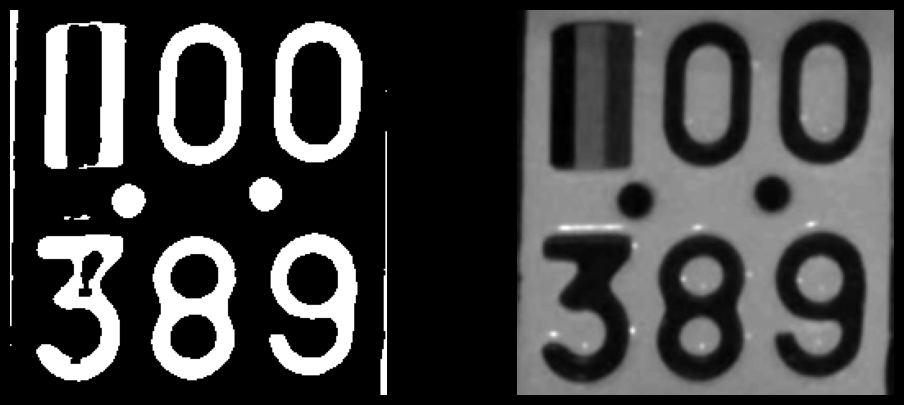

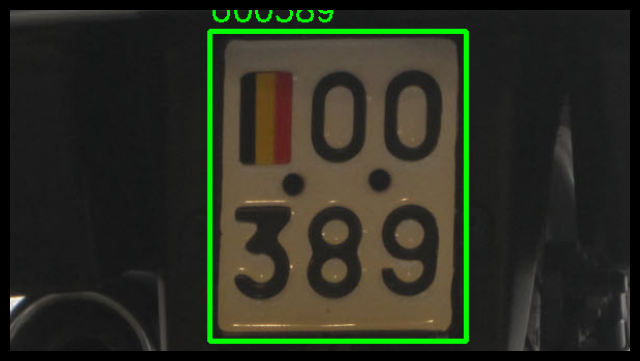

Placa: U00589
Archivo:  images107.jpg
C:/Users/yanet/Documents/CV/placas/images107.jpg


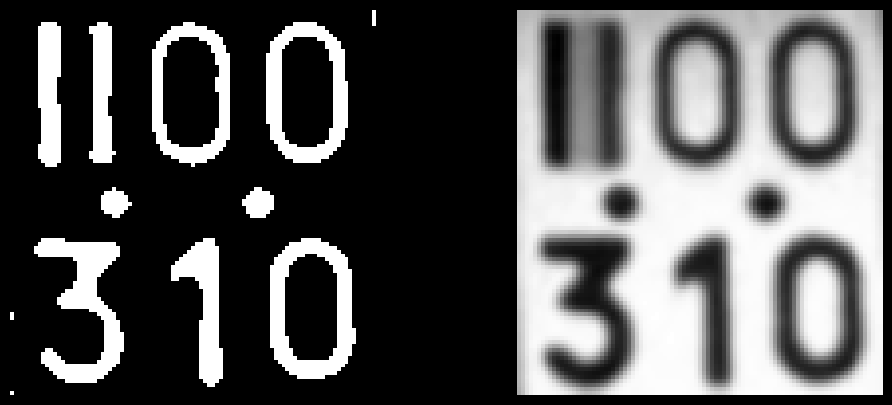

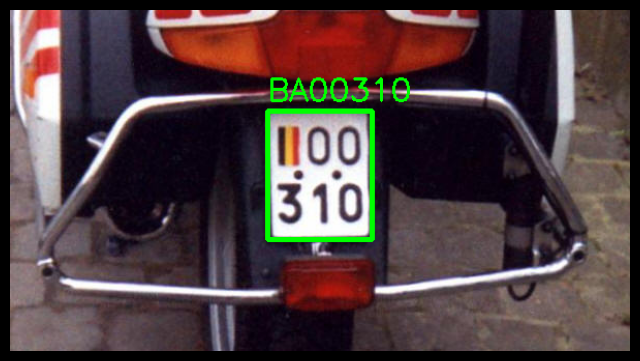

Placa: BA00310
Archivo:  images108.jpg
C:/Users/yanet/Documents/CV/placas/images108.jpg


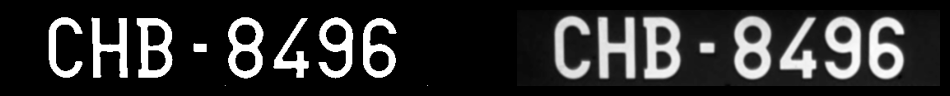

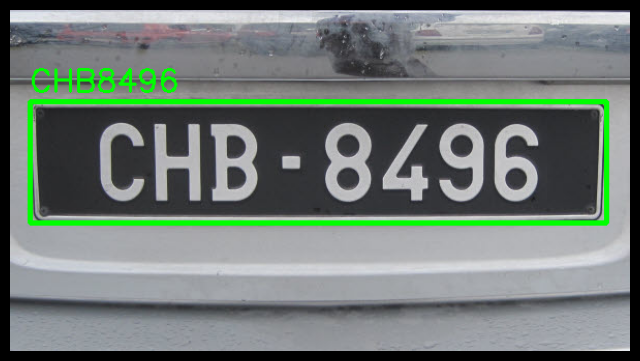

Placa: CHB8496
Archivo:  images109.jpg
C:/Users/yanet/Documents/CV/placas/images109.jpg


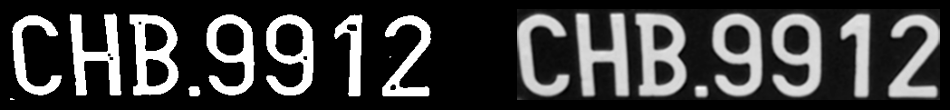

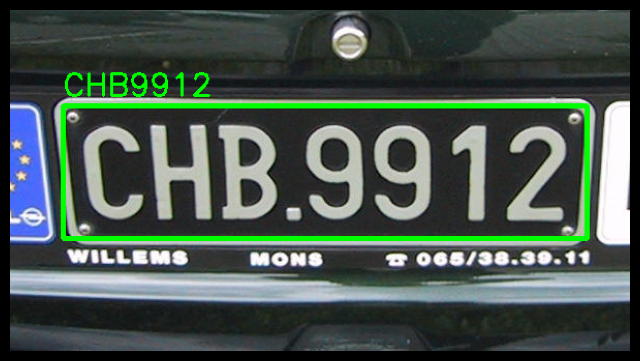

Placa: CHB9912
Archivo:  images11.jpg
C:/Users/yanet/Documents/CV/placas/images11.jpg


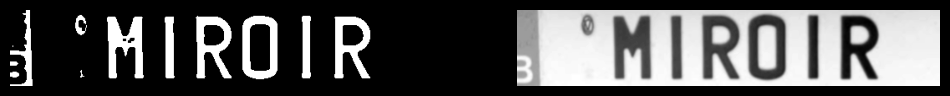

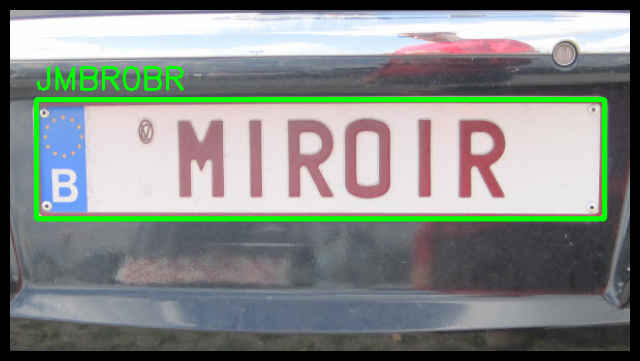

Placa: JMBR0BR
Archivo:  images110.jpg
C:/Users/yanet/Documents/CV/placas/images110.jpg


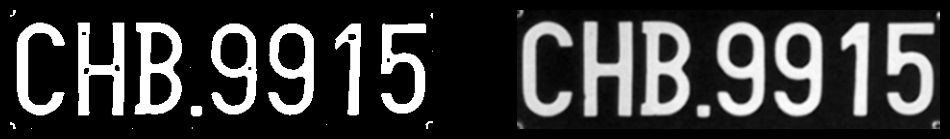

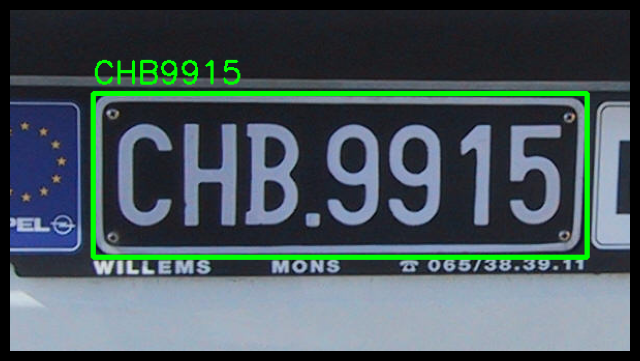

Placa: CHB9915
Archivo:  images111.jpg
C:/Users/yanet/Documents/CV/placas/images111.jpg


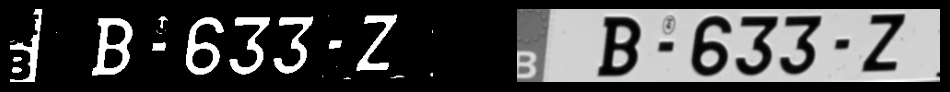

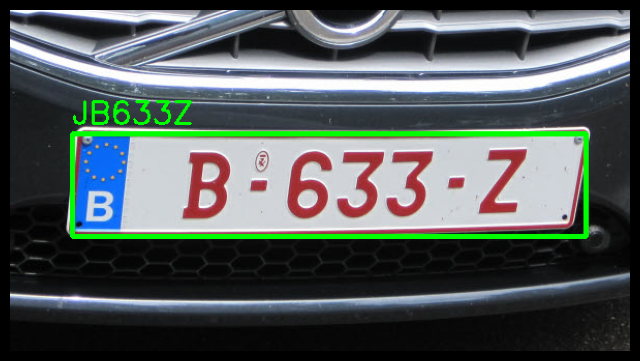

Placa: JB633Z
Archivo:  images112.jpg
C:/Users/yanet/Documents/CV/placas/images112.jpg


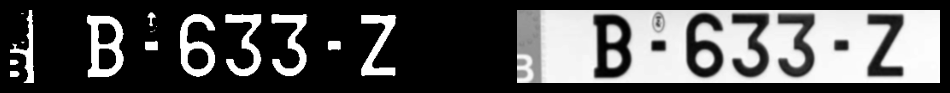

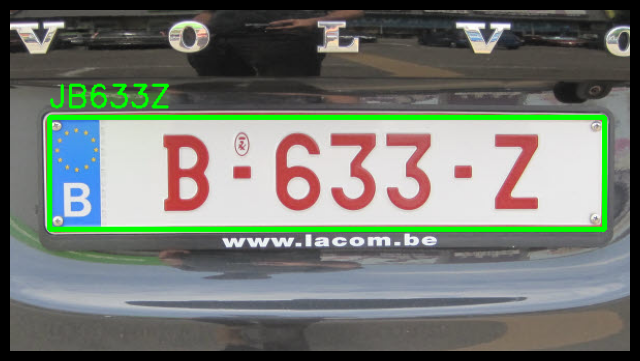

Placa: JB633Z
Archivo:  images113.jpg
C:/Users/yanet/Documents/CV/placas/images113.jpg


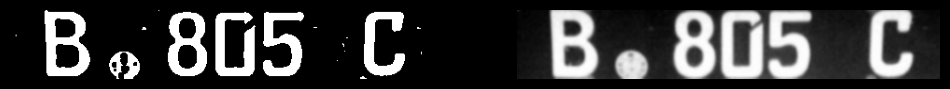

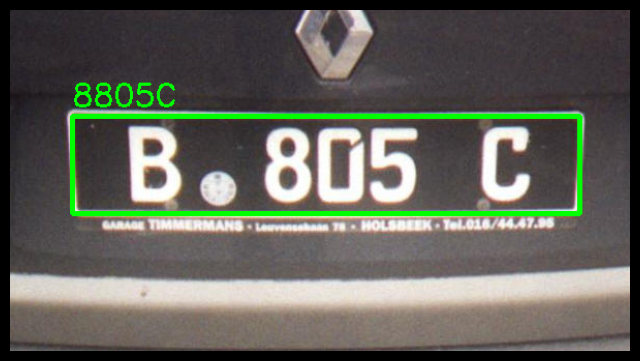

Placa: 8805C
Archivo:  images114.jpg
C:/Users/yanet/Documents/CV/placas/images114.jpg


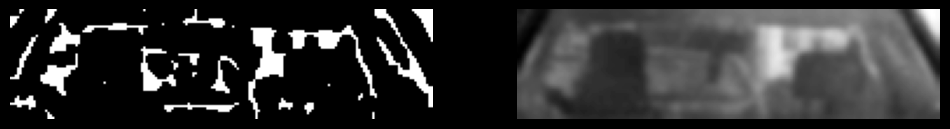

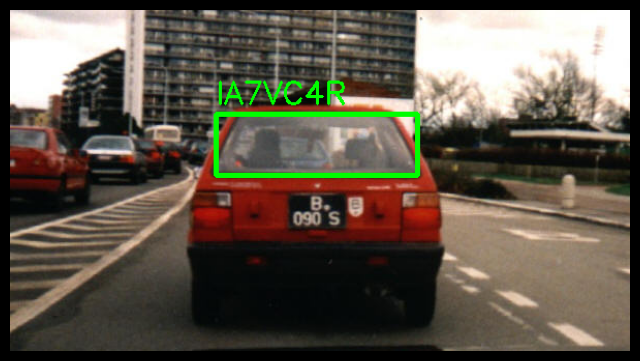

Placa: IA7VC4R
Archivo:  images115.jpg
C:/Users/yanet/Documents/CV/placas/images115.jpg


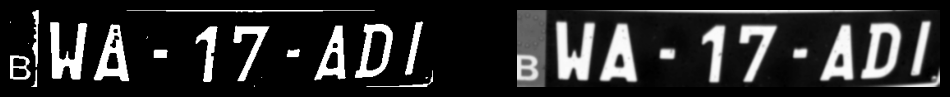

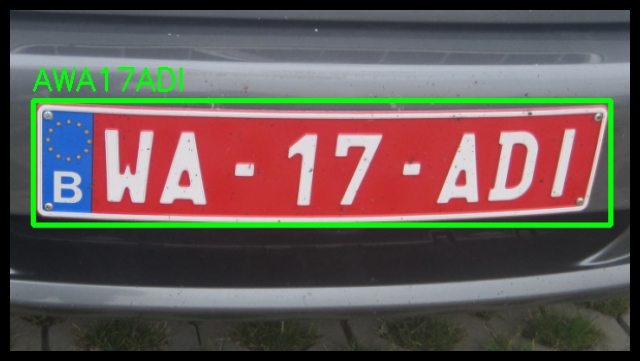

Placa: AWA17ADI
Archivo:  images116.jpg
C:/Users/yanet/Documents/CV/placas/images116.jpg


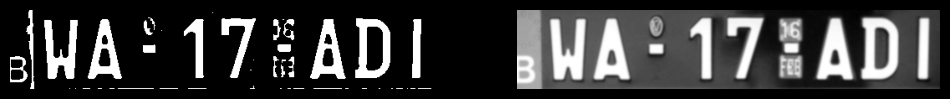

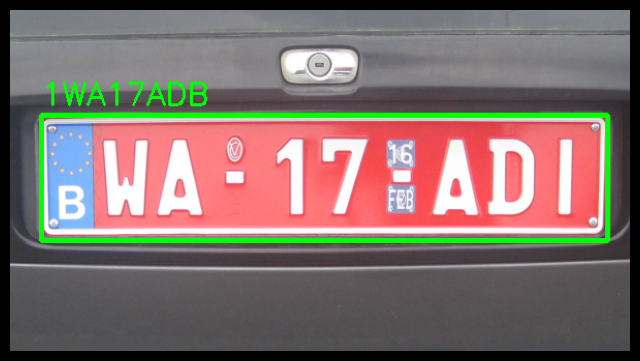

Placa: 1WA17ADB
Archivo:  images117.jpg
C:/Users/yanet/Documents/CV/placas/images117.jpg


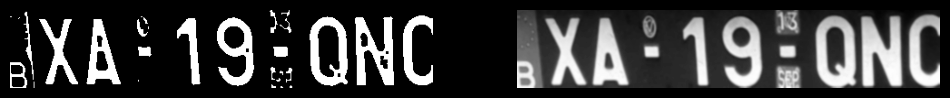

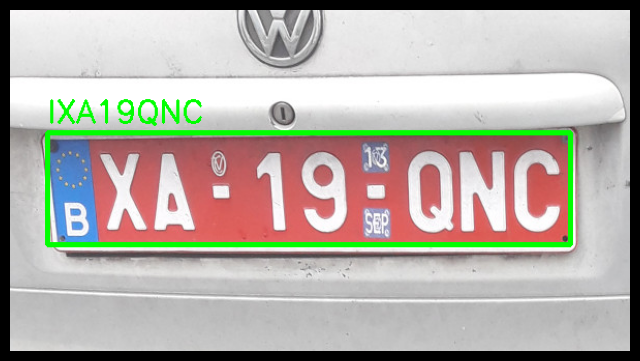

Placa: IXA19QNC


In [78]:
archivos = os.listdir(PATH)
c = 0
for archivo in archivos:
    if archivo.endswith('.jpg'):
        print("Archivo: ", archivo)
        imagen = os.path.join(PATH, archivo)
        print((imagen))
        # imgview(imagen)
        img_, txt = final_placa(imagen)
        print(f"Placa: {txt}")

        c = c+1
        # break
        if c == 20:
            break